In [1]:
import crocoddyl
import numpy as np
import matplotlib.pyplot as plt 
import utils.unicycle as uni
from utils.plotting import plot_control_sequence, plot_state_trajectory, plot_cost, plot_convergence

from MPPI.mppi import MPPI, MPPILogger
from MPPI.mppi_ddp import MPPIDDP

## Defining the problem

Write states, u etc.

In [2]:
# Defining model and cost weights
model = crocoddyl.ActionModelUnicycle()
data = model.createData()

# Cost function is defined here -> https://github.com/loco-3d/crocoddyl/blob/3cd866def6cbeb8d35a69cbbe5accc0ec5d0ca20/include/crocoddyl/core/actions/unicycle.hxx#L20
model.costWeights = np.array([
    1,   # state weight
    1,   # control weight
])

# Terminal state cost
model_term = crocoddyl.ActionModelUnicycle()
model_term.costWeights = np.array([100, 0])

# Defining problem
T  = 20
x0 = np.array([-1,-1,1])

## Solving the OCP with DDP

In [3]:
problem = crocoddyl.ShootingProblem(x0, [ model ] * T, model_term)

# Trying to do the same initialization as in the MPPI example
# u_nom = np.zeros((T, 2))
# mppi_solver_check = MPPI(model, model_term, T, 1, 1, np.full(1, 0.1))
# x_nom, _ = mppi_solver_check.rollout_trajectory(x0, u_nom)


ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])
#ddp.solve(init_us=list(u_nom), init_xs=list(x_nom), maxiter=30)
ddp.solve()
print(f"Final DDP cost: {ddp.cost}")

Final DDP cost: 18.64170485948688
iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  1.029e+03  0.000e+00  0.000e+00  0.000e+00  1.000e-09  1.000e-09  1.0000  1.000e+00  0.000e+00  0.000e+00  0.000e+00 -1.029e+03  0.000e+00  0.000e+00
   1  1.949e+01  0.000e+00  1.010e+03  2.020e+03  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.010e+03  1.009e+03  0.000e+00  0.000e+00
   2  1.865e+01  0.000e+00  8.268e-01  1.654e+00  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  8.268e-01  8.431e-01  0.000e+00  0.000e+00
   3  1.864e+01  0.000e+00  9.073e-03  1.815e-02  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  9.073e-03  9.582e-03  0.000e+00  0.000e+00
   4  1.864e+01  0.000e+00  2.312e-04  4.624e-04  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  2.312e-04  2.534e-04  0.000e+00  0.000e+00
   5  1.864e+01  0.000e+00  1.283

In [4]:
log = ddp.getCallbacks()[0]
u_opt_ddp = np.array(log.us)
# plot_control_sequence(u_opt_ddp)

x_opt_ddp = np.array(log.xs)
ddp_costs = log.costs
# plot_state_trajectory(x_opt_ddp)

# plot_cost(log.costs)
# plot_convergence(log.costs)

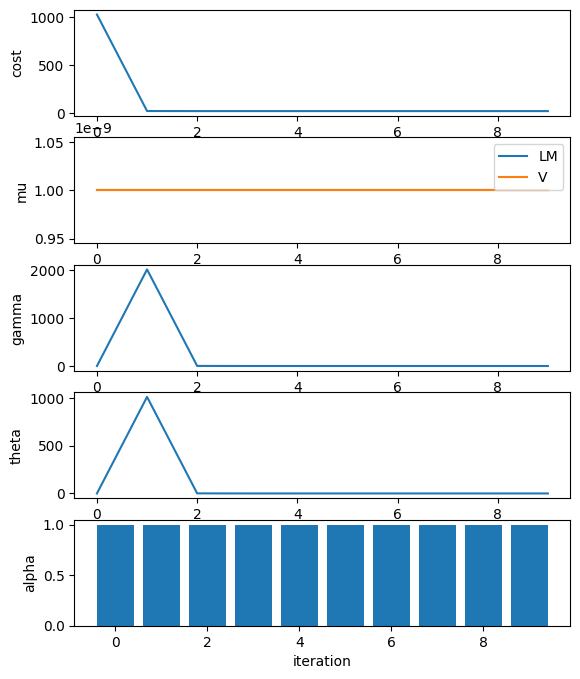

In [5]:
crocoddyl.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)

## Solving the OCP with MPPI

In [10]:
# MPPI parameters
horizon = T         # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 10    # Temperature parameter
noise_std = np.array([0.1, 0.1]) # Std dev for [linear_vel_noise, angular_vel_noise]
n_iter = 30

# Logging
logger_mppi = MPPILogger(enable_logging=True, n_log=5)

# Initial state for the unicycle: [x, y, yaw]
x0 = np.array([-1,-1,1])


print("Running MPPI solver...")
mppi_solver = MPPI(model, model_term, horizon, num_samples, lambda_param, noise_std, param_exploration=0.0, n_filt=1, logger=logger_mppi)
u_opt_mppi = mppi_solver.solve(x0, num_iterations=n_iter)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi, mppi_final_cost = mppi_solver.rollout_trajectory(x0, u_opt_mppi)
# Store the final optimized nominal control sequence in the logger
logger_mppi.set_final_controls(u_opt_mppi)
logger_mppi.set_final_state(x_opt_mppi)

print(f"Final cost of optimal trajectory: {mppi_final_cost:.4f}")

Running MPPI solver...
Iteration 1/30, Min Cost: 13287.9772, Mean Cost: 14957.7166
Iteration 2/30, Min Cost: 11725.0714, Mean Cost: 13327.3451
Iteration 3/30, Min Cost: 9723.4963, Mean Cost: 11657.9746
Iteration 4/30, Min Cost: 8191.9713, Mean Cost: 9677.0572
Iteration 5/30, Min Cost: 6584.1077, Mean Cost: 8279.1168
Iteration 6/30, Min Cost: 5197.1514, Mean Cost: 6600.5716
Iteration 7/30, Min Cost: 4373.8860, Mean Cost: 5246.0784
Iteration 8/30, Min Cost: 3639.8758, Mean Cost: 4402.7728
Iteration 9/30, Min Cost: 2759.3511, Mean Cost: 3675.7114
Iteration 10/30, Min Cost: 2163.3952, Mean Cost: 2809.7505
Iteration 11/30, Min Cost: 1611.2049, Mean Cost: 2121.8828
Iteration 12/30, Min Cost: 1133.7789, Mean Cost: 1618.6270
Iteration 13/30, Min Cost: 707.5546, Mean Cost: 1166.9118
Iteration 14/30, Min Cost: 439.4919, Mean Cost: 733.1091
Iteration 15/30, Min Cost: 259.7485, Mean Cost: 461.0985
Iteration 16/30, Min Cost: 140.1652, Mean Cost: 282.4049
Iteration 17/30, Min Cost: 65.7572, Mean Cos


Plotting results...

Plotting sampled controls for Iteration 0 (with nominal U and weights)...


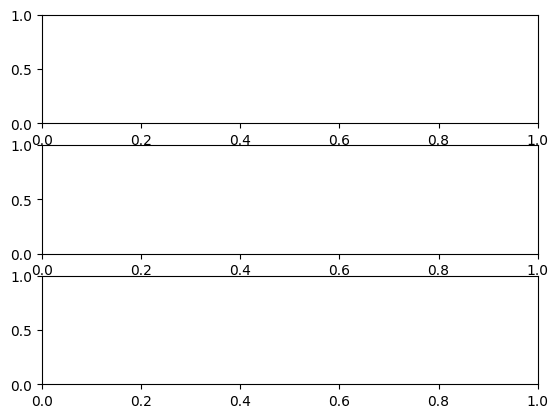

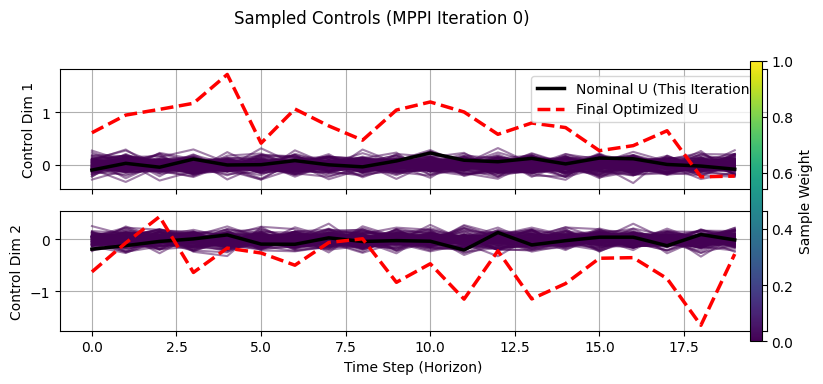


Plotting sampled states for Iteration 0 (with nominal X)...

Plotting sampled controls for Iteration 1 (with nominal U and weights)...


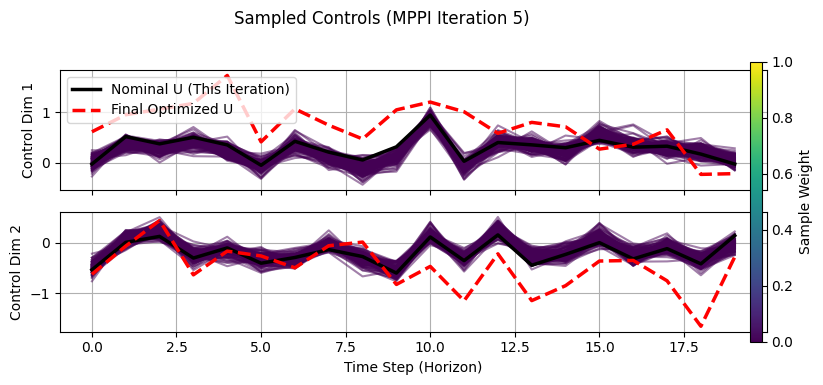


Plotting sampled controls for Iteration 2 (with nominal U and weights)...


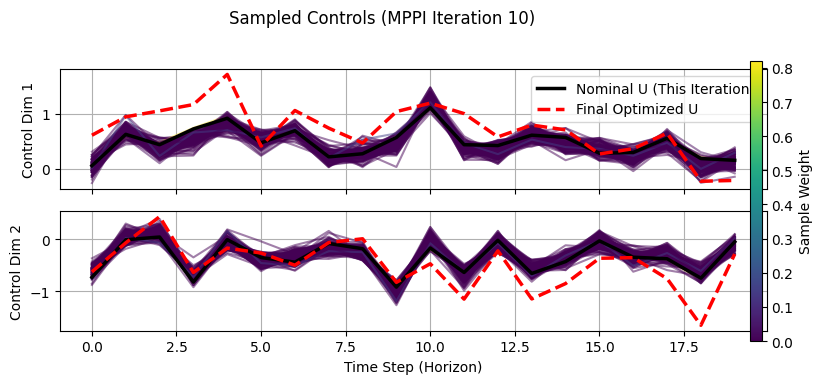


Plotting sampled controls for Iteration 3 (with nominal U and weights)...


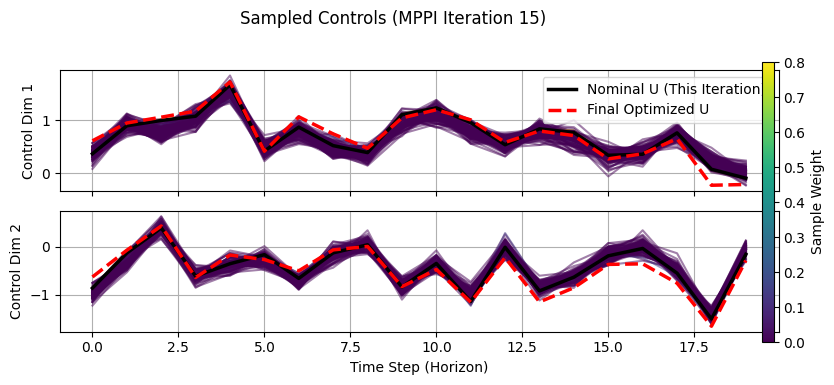


Plotting sampled controls for Iteration 4 (with nominal U and weights)...


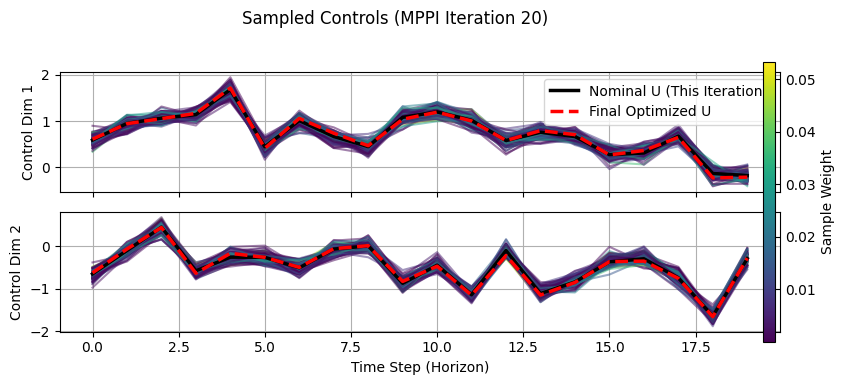


Plotting sampled controls for Iteration 5 (with nominal U and weights)...


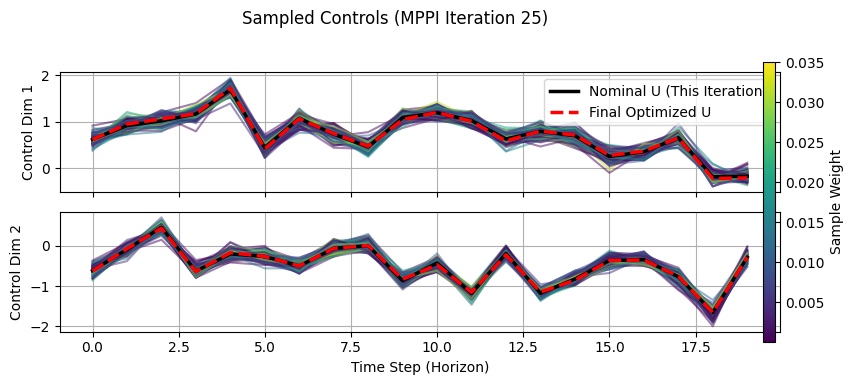


Plotting sampled states for Iteration 5 (with nominal X)...


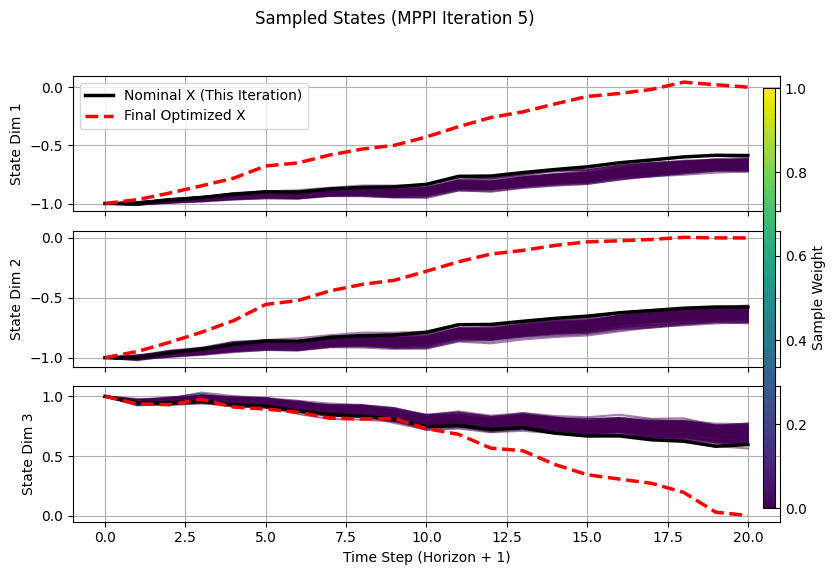

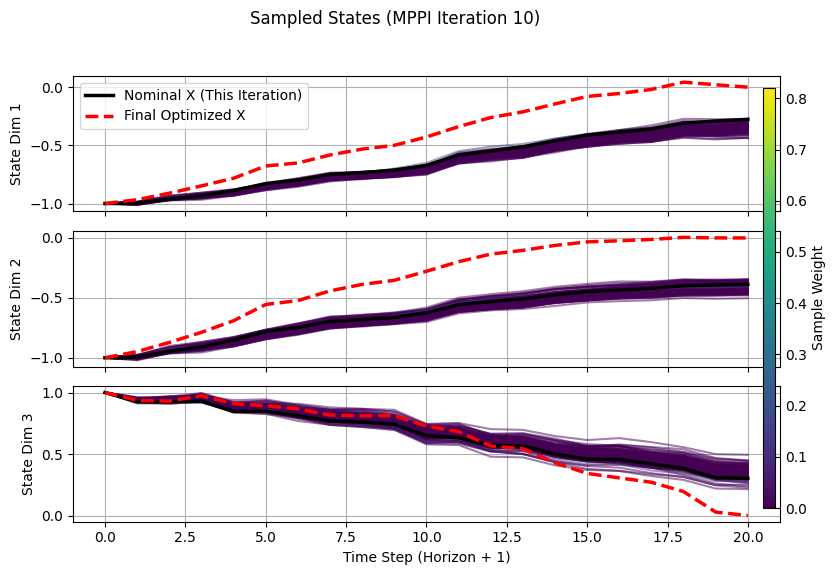

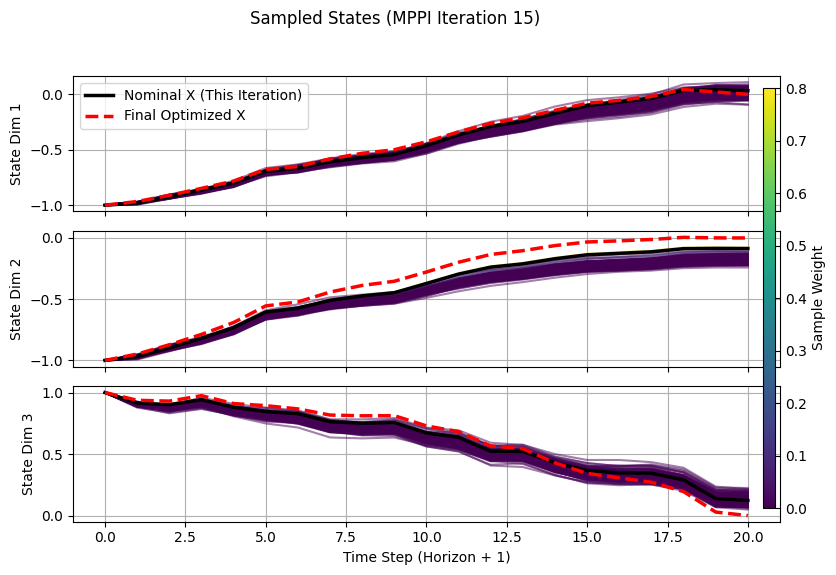

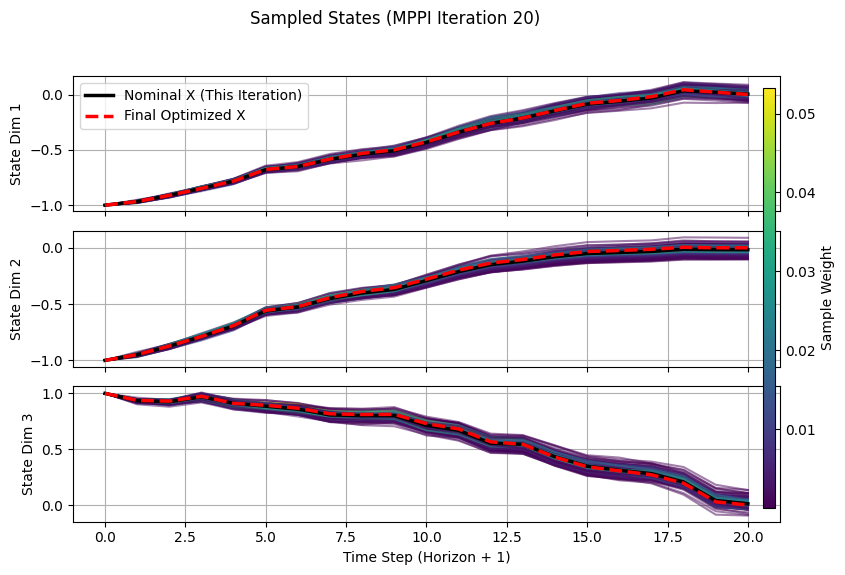

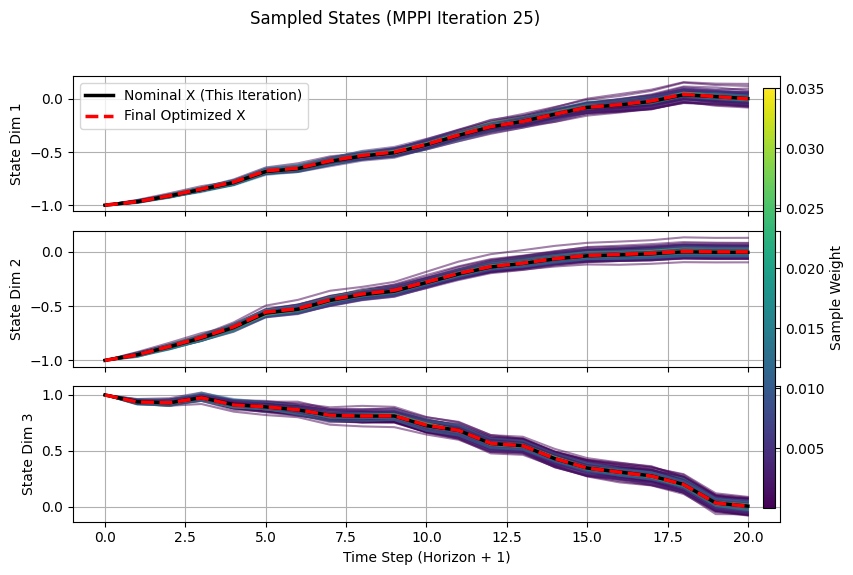

In [11]:
# 3. Use the logger to plot the collected data
print("\nPlotting results...")
# logger.plot_total_cost()
fig, axes = plt.subplots(3, 1)
# Plot sampled controls for the first detailed log (actual MPPI iteration 0)
# Showing nominal U for that iteration, and coloring by weight
if logger_mppi.sampled_controls_hist:
    pass
    print("\nPlotting sampled controls for Iteration 0 (with nominal U and weights)...")
    logger_mppi.plot_sampled_controls(iteration_index_in_log=0,
                                        num_samples_to_plot=100,
                                        plot_nominal_controls_for_this_iter=True,
                                        plot_final_nominal_controls=True,
                                        color_by_weight=True)

    # Plot sampled states for the first detailed log (actual MPPI iteration 0)
    print("\nPlotting sampled states for Iteration 0 (with nominal X)...")
    logger_mppi.plot_sampled_states(iteration_index_in_log=0,
                                    num_samples_to_plot=100,
                                    plot_nominal_states_for_this_iter=True,
                                    plot_final_nominal_states=True,
                                    color_by_weight=True,
                                    fig=fig, axes=axes)

# Plot for a later detailed log (e.g., actual MPPI iteration 5, if it exists)

if len(logger_mppi.sampled_controls_hist) > 1:
    pass
    for i in range(1, len(logger_mppi.sampled_cost)):
        print(f"\nPlotting sampled controls for Iteration {i} (with nominal U and weights)...")
        logger_mppi.plot_sampled_controls(iteration_index_in_log=i, # This refers to the 2nd logged detailed iteration
                                            num_samples_to_plot=100,
                                            plot_nominal_controls_for_this_iter=True,
                                            plot_final_nominal_controls=True,
                                            color_by_weight=True)
    print("\nPlotting sampled states for Iteration 5 (with nominal X)...")
    for i in range(1, len(logger_mppi.sampled_cost)):
        logger_mppi.plot_sampled_states(iteration_index_in_log=i,
                                        num_samples_to_plot=100,
                                        plot_nominal_states_for_this_iter=True,
                                        plot_final_nominal_states=True,
                                        color_by_weight=True)

In [8]:
# logger.plot_sampled_cost_histogram(iteration_index_in_log=2, bins=30)
# logger.plot_weights_histogram(iteration_index_in_log=1, bins=10)


## Plots

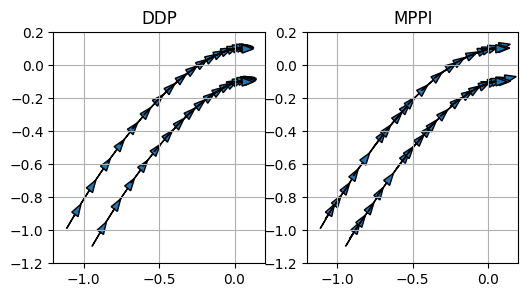

In [12]:
# plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
uni.plotUnicycleSolution(x_opt_ddp, axs[0])
uni.plotUnicycleSolution(x_opt_mppi, axs[1])

axs[0].set_title("DDP")
axs[1].set_title("MPPI")

for ax in axs:
    ax.set_xlim(-1.2, 0.2)
    ax.set_ylim(-1.2, 0.2)
    ax.grid()
# uni.plotUnicycleSolution(X_optimal, ax)
# ax.set_xlim([-1.5, 0.5])
# ax.set_ylim([-1.5, 0.5])
# ax.grid()

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

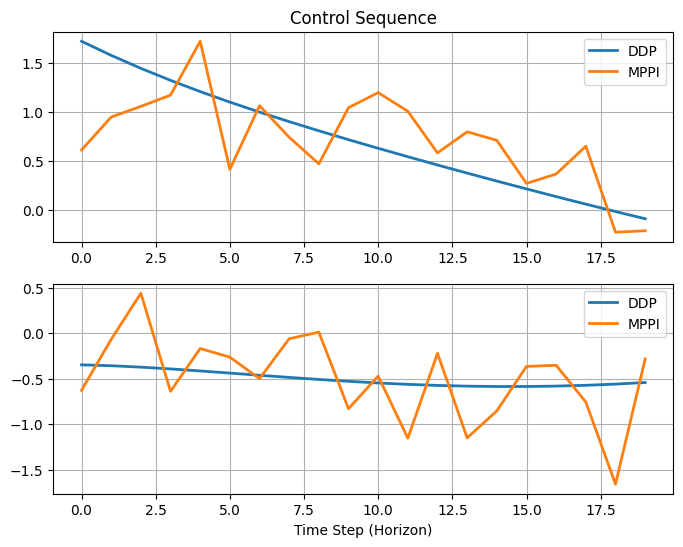

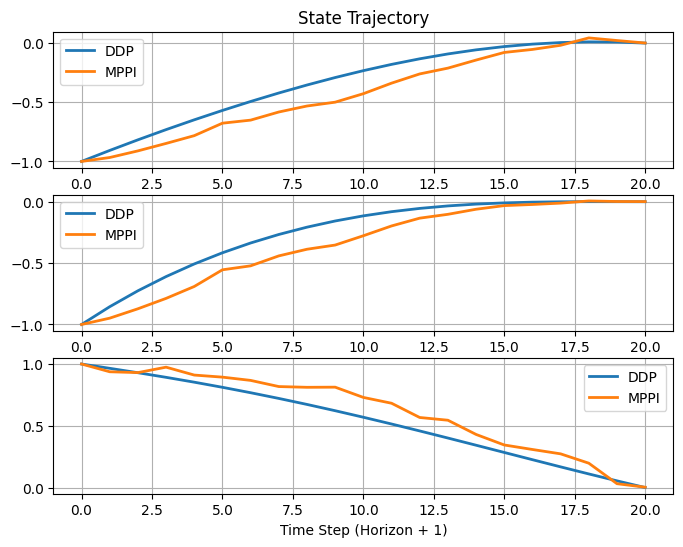

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
plot_control_sequence(u_opt_ddp, axs, labels=["DDP"]*2)
plot_control_sequence(u_opt_mppi, axs, labels=["MPPI"]*2)

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
plot_state_trajectory(x_opt_ddp, axs, labels=["DDP"]*3)
plot_state_trajectory(x_opt_mppi, axs, labels=["MPPI"]*3)

## Solving OCP with MPPI-DDP

In [14]:
# MPPI parameters
horizon = T         # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 10    # Temperature parameter
noise_std = np.array([0.1, 0.1]) # Std dev for [linear_vel_noise, angular_vel_noise]
n_iter = 10

# Logging
logger_mppi_ddp = MPPILogger(enable_logging=True, n_log=5)

# Initial state for the unicycle: [x, y, yaw]
x0 = np.array([-1,-1,1])

print("Running MPPI-DDP solver...")

mppi_ddp_solver = MPPIDDP(model, model_term, horizon, num_samples, lambda_param, noise_std,
                      ddp_problem=problem,
                      param_exploration=0.0, n_filt=1, logger=logger_mppi_ddp,
                      num_ddp_replace=1)
u_opt_mppi_ddp = mppi_ddp_solver.solve(x0, num_iterations=n_iter)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi_ddp, final_cost_mppi_ddp = mppi_ddp_solver.rollout_trajectory(x0, u_opt_mppi_ddp)
# Store the final optimized nominal control sequence in the logger
logger_mppi_ddp.set_final_controls(u_opt_mppi_ddp)
logger_mppi_ddp.set_final_state(x_opt_mppi_ddp)

print(f"Final cost of optimal trajectory: {final_cost_mppi_ddp:.4f}")

Running MPPI-DDP solver...
Iteration 1/10, Min Cost: 1202.9850, Mean Cost: 14959.2416, DDP Cost: 1202.9850, DDP converged: False
Iteration 2/10, Min Cost: 28.4108, Mean Cost: 1224.6813, DDP Cost: 28.4108, DDP converged: False
Iteration 3/10, Min Cost: 18.6797, Mean Cost: 46.1737, DDP Cost: 18.6797, DDP converged: False
Iteration 4/10, Min Cost: 18.6780, Mean Cost: 45.8661, DDP Cost: 18.6780, DDP converged: False
Iteration 5/10, Min Cost: 18.6727, Mean Cost: 42.6480, DDP Cost: 18.6727, DDP converged: False
Iteration 6/10, Min Cost: 18.4467, Mean Cost: 39.6000, DDP Cost: 18.6739, DDP converged: False
Iteration 7/10, Min Cost: 18.6707, Mean Cost: 43.3470, DDP Cost: 18.6707, DDP converged: False
Iteration 8/10, Min Cost: 18.5956, Mean Cost: 40.0024, DDP Cost: 18.6681, DDP converged: False
Iteration 9/10, Min Cost: 18.6650, Mean Cost: 37.8430, DDP Cost: 18.6650, DDP converged: False
Iteration 10/10, Min Cost: 18.6601, Mean Cost: 42.1678, DDP Cost: 18.6601, DDP converged: False

Rolling out 

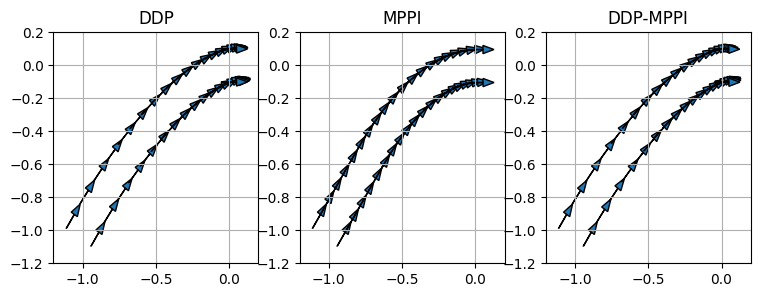

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3)) # Changed to 1 row, 3 columns, and adjusted figsize

uni.plotUnicycleSolution(x_opt_ddp, axs[0])
uni.plotUnicycleSolution(x_opt_mppi, axs[1])
uni.plotUnicycleSolution(x_opt_mppi_ddp, axs[2]) # Added the third plot for ddp-mppi

axs[0].set_title("DDP")
axs[1].set_title("MPPI")
axs[2].set_title("DDP-MPPI") # Added title for the third plot

for ax in axs:
    ax.set_xlim(-1.2, 0.2)
    ax.set_ylim(-1.2, 0.2)
    ax.grid()

array([<Axes: title={'center': 'State Trajectory'}>, <Axes: >,
       <Axes: xlabel='Time Step (Horizon + 1)'>], dtype=object)

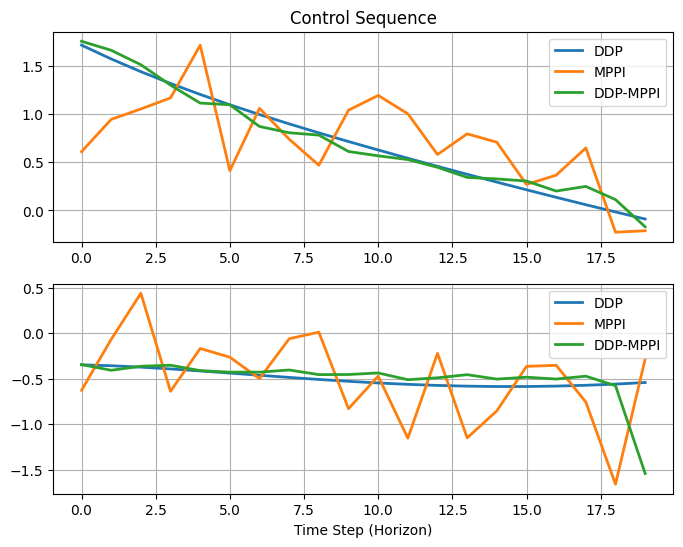

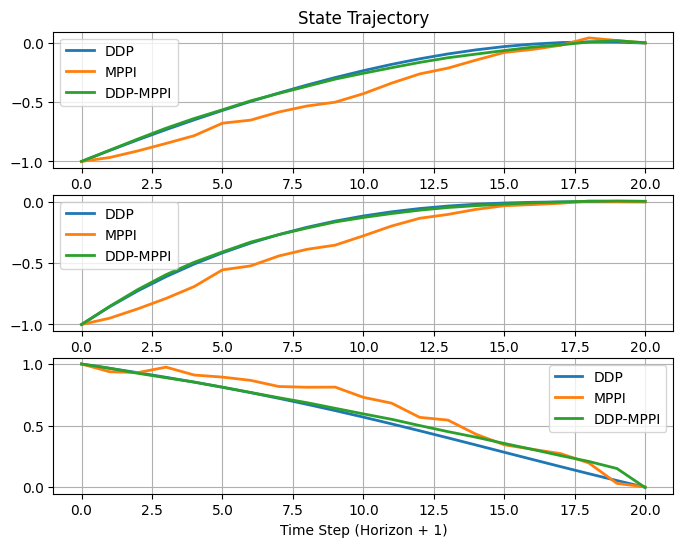

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
plot_control_sequence(u_opt_ddp, axs, labels=["DDP"]*2)
plot_control_sequence(u_opt_mppi, axs, labels=["MPPI"]*2)
plot_control_sequence(u_opt_mppi_ddp, axs, labels=["DDP-MPPI"]*2) # Added DDP-MPPI control sequence

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
plot_state_trajectory(x_opt_ddp, axs, labels=["DDP"]*3)
plot_state_trajectory(x_opt_mppi, axs, labels=["MPPI"]*3)
plot_state_trajectory(x_opt_mppi_ddp, axs, labels=["DDP-MPPI"]*3) # Added DDP-MPPI state trajectory

(10.0, 50.0)

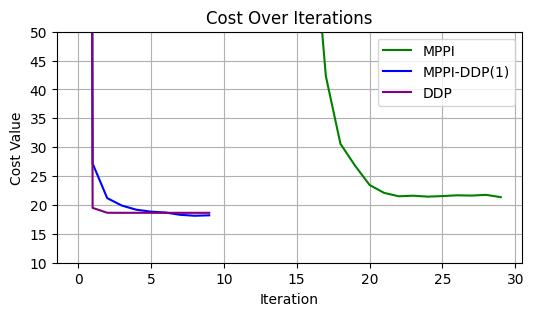

In [16]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
plot_cost(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_cost(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_cost(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_ylim(10, 50)

(-100.0, 10.0)

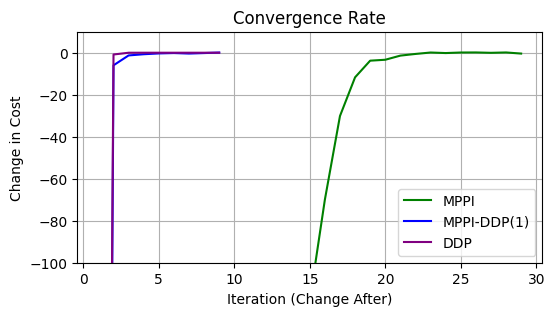

In [17]:
# Create a figure and a single subplot for the cost histories
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]

# Plot each cost history on the same subplot
plot_convergence(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
plot_convergence(logger_mppi_ddp.total_cost_hist, ax=ax, color="blue", label="MPPI-DDP(1)")
plot_convergence(ddp_costs, ax=ax, color="purple", label="DDP")
ax.legend()
ax.set_ylim(-100, 10)